## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [3]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

# import xgboost as xgb

import matplotlib.pyplot as plt
# import seaborn as sb
%matplotlib inline

# load in the data
train_data = pd.read_csv('./training.csv')
X_train = train_data.drop('purchase', axis=1)
y_train = train_data['purchase']
X_trainl, X_testl, y_trainl, y_testl = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [4]:
train_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


In [5]:
print()
print("Maximum Values in Control and Experimental Groups")
print()
print(X_trainl.groupby('Promotion').max())
print()
print()
print("Minimum Values in Control and Experimental Groups")
print()
print(X_trainl.groupby('Promotion').min())


Maximum Values in Control and Experimental Groups

               ID  V1         V2        V3  V4  V5  V6  V7
Promotion                                                 
No         126184   3  49.170628  1.691984   2   4   4   2
Yes        126175   3  49.823708  1.691984   2   4   4   2


Minimum Values in Control and Experimental Groups

           ID  V1        V2       V3  V4  V5  V6  V7
Promotion                                           
No          1   0  8.939305 -1.68455   1   1   1   1
Yes         8   0  7.104007 -1.68455   1   1   1   1


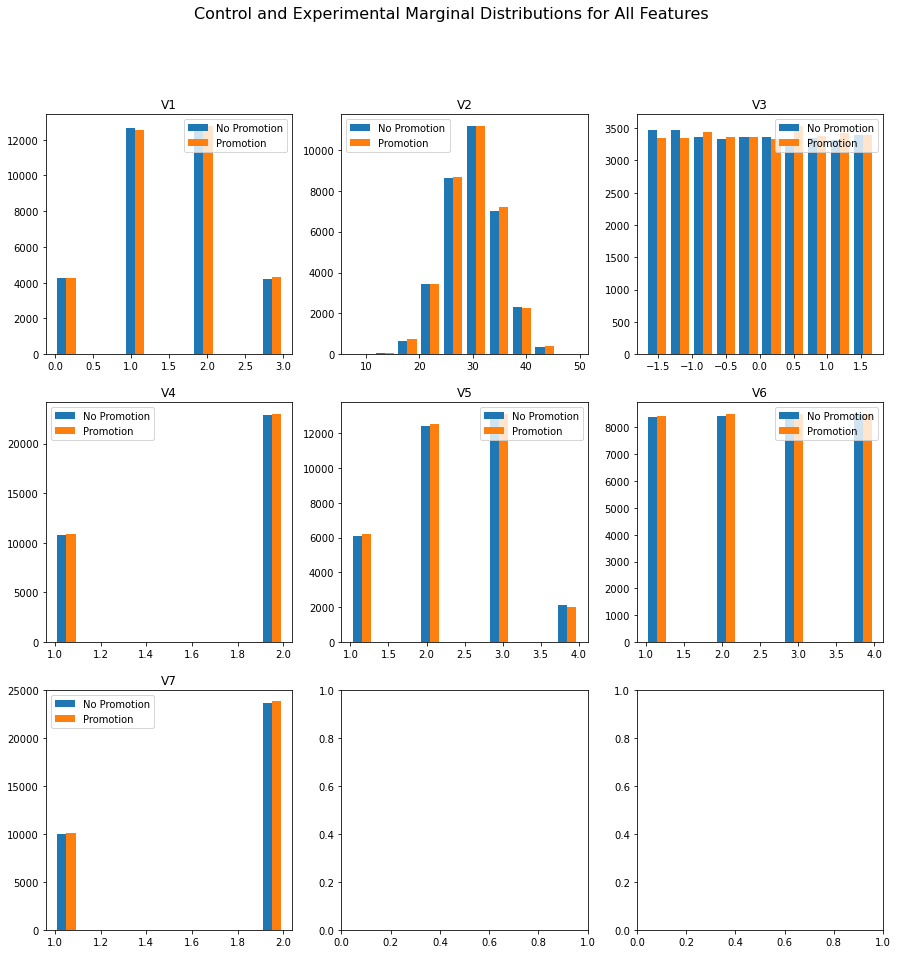

In [6]:
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']


# Compare the control and experimental marginal distributions
# for each feature
fig, axs = plt.subplots(3, 3)
for i, feature in enumerate(features):
    no_promote = X_trainl[X_trainl['Promotion'] == 'No'][feature]
    promote = X_trainl[X_trainl['Promotion'] == 'Yes'][feature]
    ax = axs[i // 3][i % 3]
    ax.hist([no_promote, promote])
    ax.legend(["No Promotion",  "Promotion"])
    ax.set_title(feature)
fig.set_size_inches(15, 15)
plt.suptitle("Control and Experimental Marginal Distributions for All Features", fontsize=16)
plt.show()

### Initial Thoughts

We don't have any real knowledge of what these features represent. V1 looked like it might be some sort of count (just based on being the only variable starting at 0), and thus a discrete linear rather than a categorical variable, but that 1:3:3:1 pattern makes me suspicious of that reading. Still, we can test it either way. V2 looks like it can be safely normalized, and V3 definitely shouldn't be. It's uniform, so it's easy enough to restrict the range (which might not be a bad idea), but without any knowledge about what it means and without a significant scale problem it seems needlessly destructive. Of course, any of these could be discrete linear and not categorical! Still, I'm going to boldly press forward with V5 and V6 as categorical and only check V1 (binary categorical is both a safe bet and encoded the same way, so V4 and V7 don't matter). However, we'd really like to say that the whole distribution is comparable for both experimental and control populations to justify some possible strategies. The dimension is too high, though, so let's just run some pairwise checks.

In [7]:
local_train_data = pd.concat([X_trainl, y_trainl], axis=1)
promotion = local_train_data[local_train_data['Promotion'] == 'Yes']
no_promotion = local_train_data[local_train_data['Promotion'] == 'No']

In [65]:
promotion.corr()

,ID,V1,V2,V3,V4,V5,V6,V7,purchase,lin_reg_diff,log_reg_diff
ID,1.000000,-0.000319,0.001688,0.000530,-0.010264,0.000724,-0.005035,0.002017,0.003730,-0.006444,-0.006925
V1,-0.000319,1.000000,-0.004428,0.013325,0.003865,-0.004041,-0.003510,0.001893,-0.007066,-0.010612,0.084174
V2,0.001688,-0.004428,1.000000,-0.005051,-0.001916,-0.008362,-0.002040,-0.002699,-0.002190,-0.004615,0.035301
V3,0.000530,0.013325,-0.005051,1.000000,0.000985,-0.000081,0.008643,-0.001074,-0.020381,-0.294985,-0.289383
V4,-0.010264,0.003865,-0.001916,0.000985,1.000000,-0.002847,-0.006473,-0.000923,0.054323,0.708907,0.698457
V5,0.000724,-0.004041,-0.008362,-0.000081,-0.002847,1.000000,0.002853,0.004897,0.013622,0.132833,0.065628
V6,-0.005035,-0.003510,-0.002040,0.008643,-0.006473,0.002853,1.000000,0.000281,-0.002530,-0.020779,0.024355
V7,0.002017,0.001893,-0.002699,-0.001074,-0.000923,0.004897,0.000281,1.000000,-0.005725,-0.083766,-0.095316
purchase,0.003730,-0.007066,-0.002190,-0.020381,0.054323,0.013622,-0.002530,-0.005725,1.000000,0.072686,0.072758
lin_reg_diff,-0.006444,-0.010612,-0.004615,-0.294985,0.708907,0.132833,-0.020779,-0.083766,0.072686,1.000000,0.987295


In [66]:
no_promotion.corr()

,ID,V1,V2,V3,V4,V5,V6,V7,purchase,lin_reg_diff,log_reg_diff
ID,1.000000,-0.010625,-0.002507,0.006194,-0.006580,0.002929,0.001966,0.007549,0.008876,-0.004794,-0.004942
V1,-0.010625,1.000000,-0.001812,-0.000267,0.004624,0.001408,-0.003618,0.004145,-0.009419,-0.003766,0.089976
V2,-0.002507,-0.001812,1.000000,0.001375,0.011969,0.005360,-0.010639,-0.000906,-0.002677,0.007057,0.046423
V3,0.006194,-0.000267,0.001375,1.000000,0.007487,-0.003643,0.000721,0.001461,0.002381,-0.294873,-0.290230
V4,-0.006580,0.004624,0.011969,0.007487,1.000000,0.004776,0.005050,-0.004067,0.002711,0.708009,0.697367
V5,0.002929,0.001408,0.005360,-0.003643,0.004776,1.000000,-0.008694,0.004422,0.005606,0.140793,0.075199
V6,0.001966,-0.003618,-0.010639,0.000721,0.005050,-0.008694,1.000000,0.004379,-0.001521,-0.011392,0.033291
V7,0.007549,0.004145,-0.000906,0.001461,-0.004067,0.004422,0.004379,1.000000,0.000750,-0.088192,-0.099987
purchase,0.008876,-0.009419,-0.002677,0.002381,0.002711,0.005606,-0.001521,0.000750,1.000000,-0.002217,-0.003589
lin_reg_diff,-0.004794,-0.003766,0.007057,-0.294873,0.708009,0.140793,-0.011392,-0.088192,-0.002217,1.000000,0.987578


In [67]:
X_trainl.corr()

,ID,V1,V2,V3,V4,V5,V6,V7
ID,1.000000,-0.005492,-0.000403,0.003331,-0.008418,0.001845,-0.001537,0.004780
V1,-0.005492,1.000000,-0.003127,0.006597,0.004230,-0.001354,-0.003562,0.003015
V2,-0.000403,-0.003127,1.000000,-0.001845,0.004979,-0.001536,-0.006316,-0.001808
V3,0.003331,0.006597,-0.001845,1.000000,0.004218,-0.001898,0.004682,0.000195
V4,-0.008418,0.004230,0.004979,0.004218,1.000000,0.000961,-0.000732,-0.002489
V5,0.001845,-0.001354,-0.001536,-0.001898,0.000961,1.000000,-0.002912,0.004659
V6,-0.001537,-0.003562,-0.006316,0.004682,-0.000732,-0.002912,1.000000,0.002325
V7,0.004780,0.003015,-0.001808,0.000195,-0.002489,0.004659,0.002325,1.000000


Correlation is a rough check, especially for presumed categorical variables. Mostly, it's just tempting because it's one command, and you can scan it very quickly. A better tool: the 2D histogram

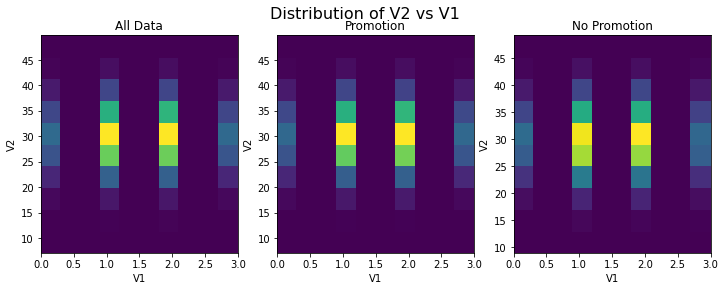

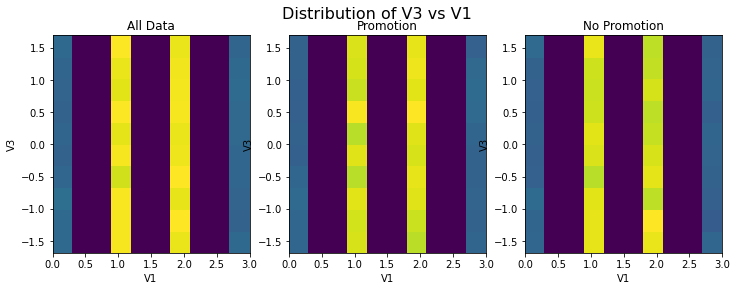

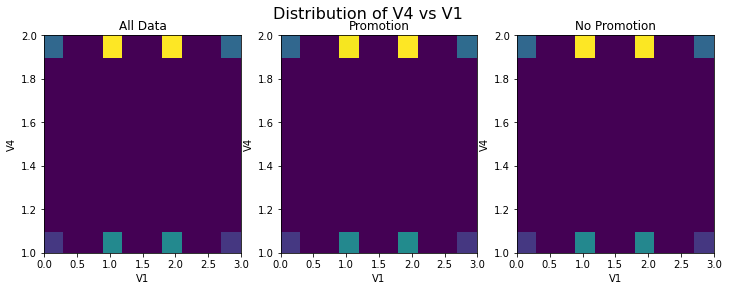

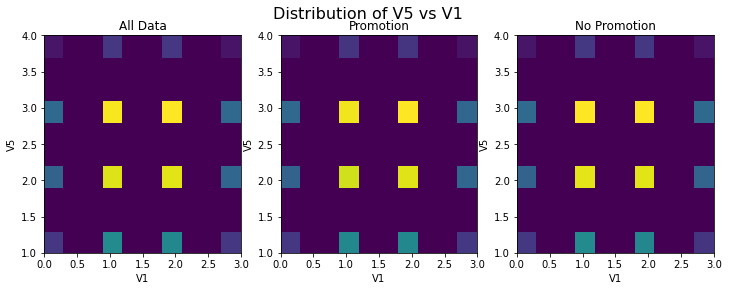

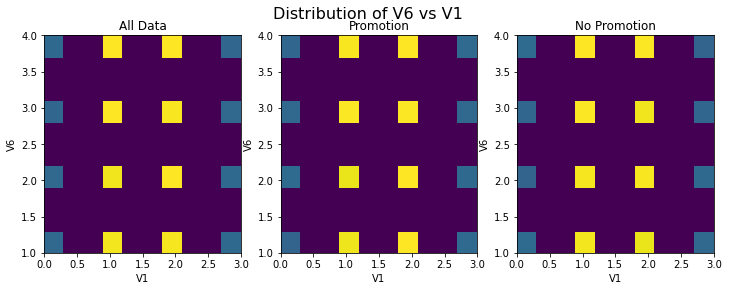

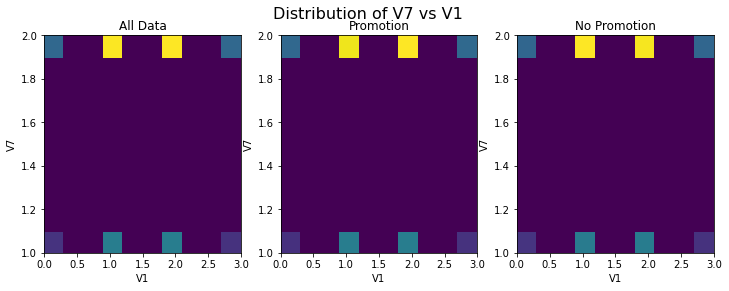

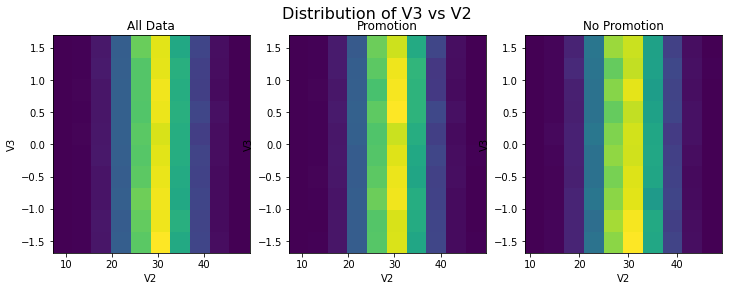

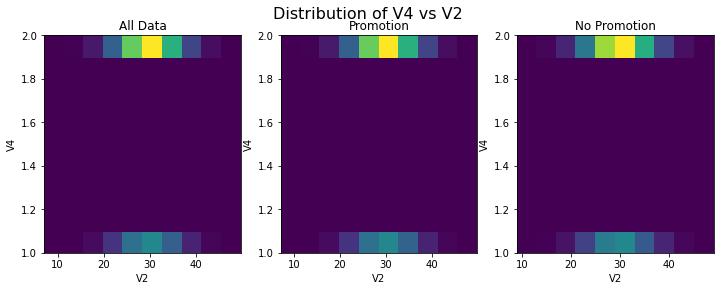

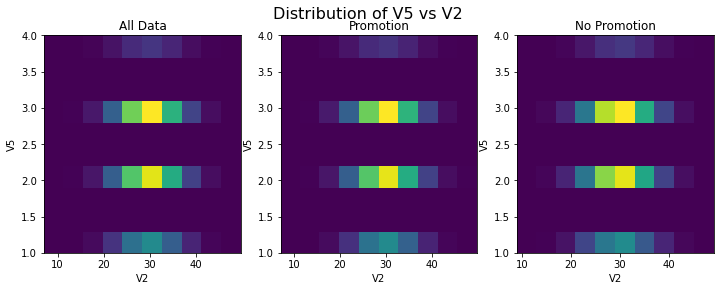

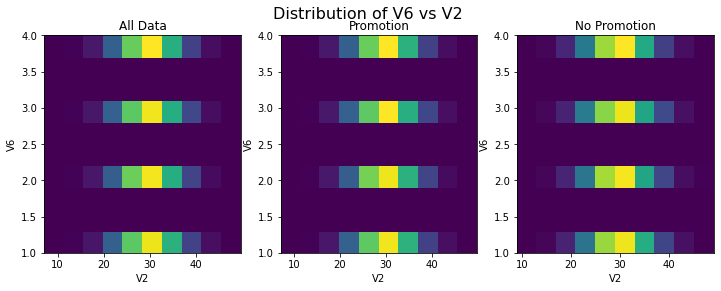

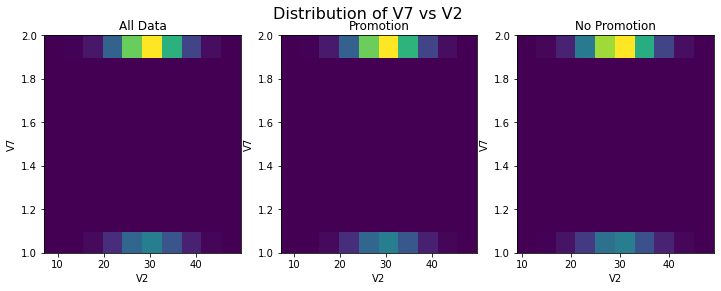

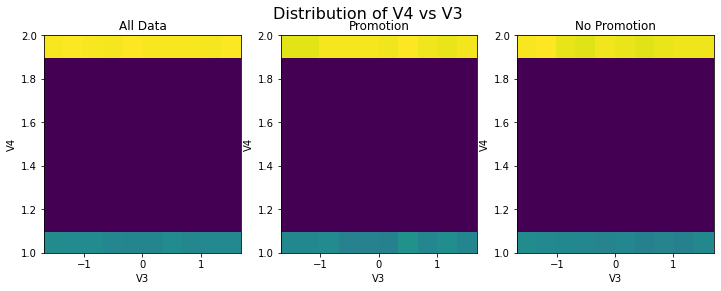

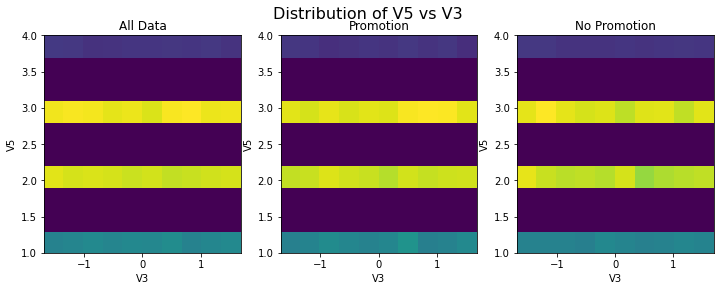

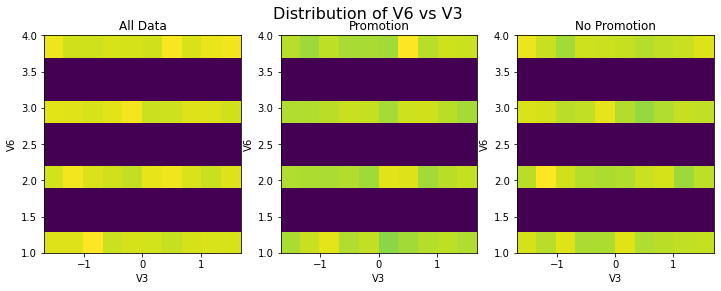

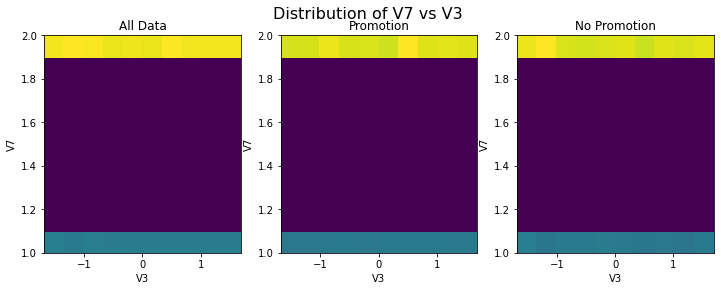

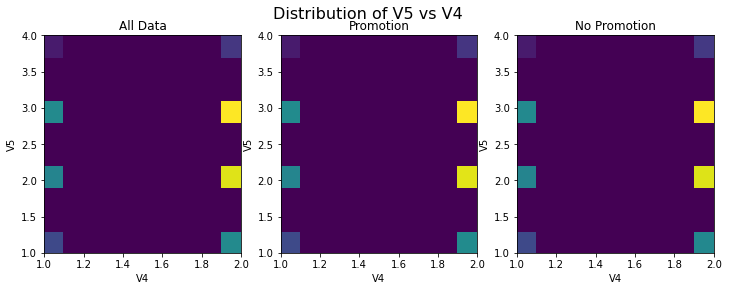

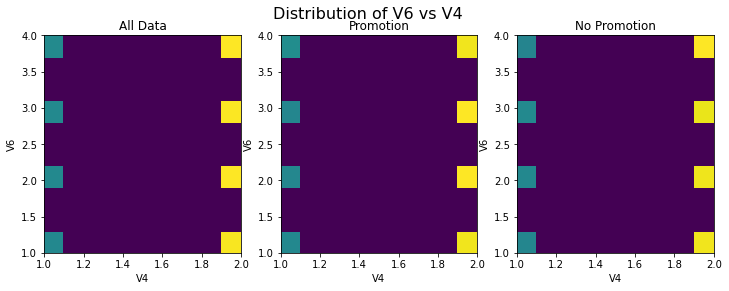

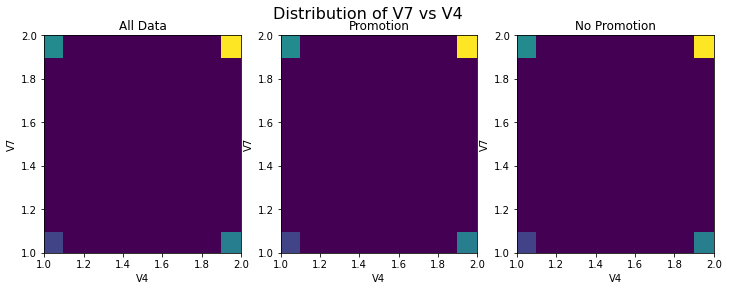

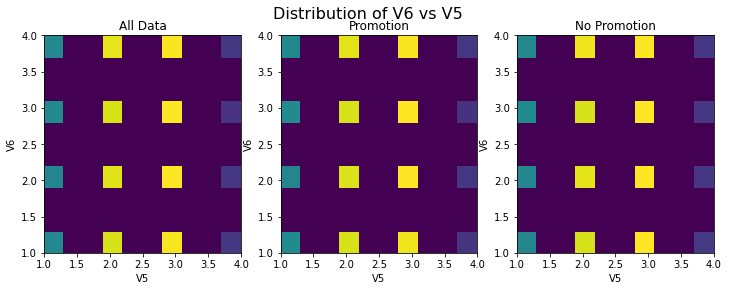

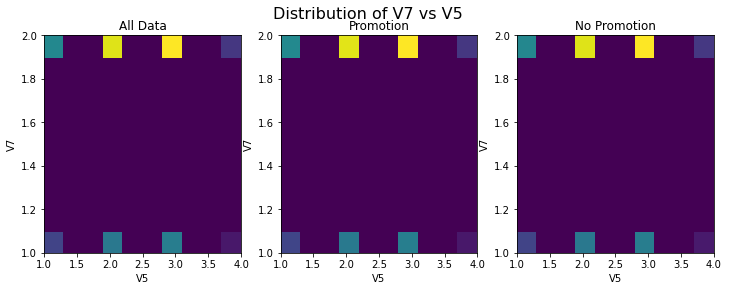

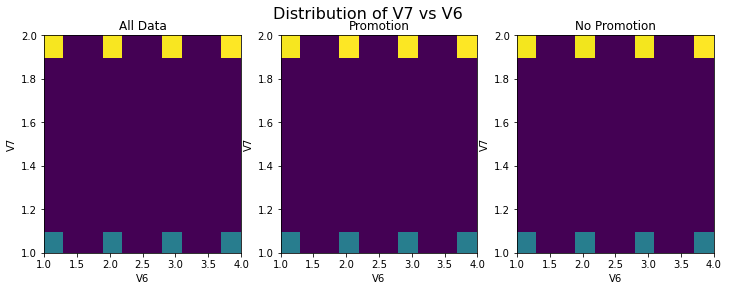

In [11]:
for var1 in range(7):
    for var2 in range(var1 + 1, 7):
        v1 = "V{}".format(var1 + 1)
        v2 = "V{}".format(var2 + 1)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        fig.set_size_inches(12, 4)
        ax1.hist2d(X_trainl[v1], X_trainl[v2])
        ax1.set_title("All Data")
        ax1.set_xlabel("{}".format(v1))
        ax1.set_ylabel("{}".format(v2))
        ax2.hist2d(promotion[v1], promotion[v2])
        ax2.set_title("Promotion")
        ax2.set_xlabel("{}".format(v1))
        ax2.set_ylabel("{}".format(v2))
        ax3.hist2d(no_promotion[v1], no_promotion[v2])
        ax3.set_title("No Promotion")
        ax3.set_xlabel("{}".format(v1))
        ax3.set_ylabel("{}".format(v2))
        plt.suptitle("Distribution of {} vs {}".format(v2, v1), fontsize=16)
        plt.show()

Now that's a great set of charts. I'm now totally comfortable assuming that the population given the promotion initially has the same demographics as the population not given the promotion, which just makes everything a lot easier. So let's talk about the basics of the promotion: indiscriminately applied, how much of an effect does the promotion have and how cost effective is it?

In [12]:
def inc_resp_rate(control_response, experimental_response):
    '''
    INPUT
    control_response - a pandas series of binary data indicating
                       whether or not a purchase was made
                       for the control group
    experimental_response - the above for the experimental group
    
    OUTPUT:
    irr - the incremental response rate, p(purchase_exp) - p(purchase_ctrl)
    p - an estimate of the significance of the difference, assuming a binomial variable
    '''
    n0 = control_response.size
    n1 = experimental_response.size
    n = n0 + n1
    num_0 = control_response.sum()
    num_1 = experimental_response.sum()
    num = num_0 + num_1
    p0 = num_0 / n0
    p1 = num_1 / n1
    p_hat = num / n
    denom = np.sqrt(p_hat * (1 - p_hat) * (1. / n0 + 1. / n1))
    if denom == 0:
        return p1 - p0, -1
    z = (p1 - p0) / denom
    p_val = sp.stats.norm.sf(z) # one-sided p test
    return p1 - p0, p_val

In [13]:
inc_resp_rate(no_promotion['purchase'], promotion['purchase'])

(0.009614880827783483, 4.102046618162408e-30)

Incredibly effective! The purchase rate more than doubled, and we find it hard to deny the effect. I've chosen to also return some measure of significance in this function, which sounds a lot like a function doing two things. However, I also think it's probably a good idea to make sure you don't use the incremental response rate without at least considering whether it's an artifact. Here we're just testing the assumption that these are samples from the same binomial distribution, and while a p value of 0.05 might not fill us with confidence I tend to stop counting after around 15 zeros. What about our net incremental revenue?

In [14]:
def nir(control_response, experimental_response):
    '''
    INPUT
    control_response - a pandas series of binary data indicating
                       whether or not a purchase was made
                       for the control group
    experimental_response - the above for the experimental group
    
    OUTPUT:
    nir - the net incremental revenue, experimental earnings minus intervention
          cost and control earnings
    '''
    epc = 10. # Earnings per customer
    cost = 0.15 # Cost of intervention
    total_cost = cost * experimental_response.size
    nir = epc * experimental_response.sum() - epc * control_response.sum() - total_cost
    return nir

In [15]:
nir(no_promotion['purchase'], promotion['purchase'])

-1809.6499999999996

As the price for an 80,000 person experiment that might have implications outside of this specific promotion, this was clearly worth it. As revenue, not so much. This is a reasonable meaasurement here, in that we're comparing earnings of two equally sized groups. However, surely this isn't really the desired formula? We should maximize (irr * earnings - intervention_cost) * experimental_population_size. Otherwise, we excessively penalize any reduction in the fraction of people targeted, which definitely has to go down. Let's confirm that the two measures give approximately the same answer in the case where the control and experimental groups are comparably sized.

In [16]:
def my_nir(control_response, experimental_response):
    '''
    INPUT
    control_response - a pandas series of binary data indicating
                       whether or not a purchase was made
                       for the control group
    experimental_response - the above for the experimental group
    
    OUTPUT:
    nir - the net incremental revenue, experimental earnings minus intervention
          cost and control earnings
    '''
    
    epc = 10.
    cost = 0.15
    irr, _ = inc_resp_rate(control_response, experimental_response)
    nir = (irr * epc - cost) * experimental_response.size
    return nir

In [17]:
my_nir(no_promotion['purchase'], promotion['purchase'])

-1827.2247863247858

In [18]:
promotion.shape[0] * 0.15

5089.65

Good. That should work better. Just for reference, we can check the total spent and see that we've spent $5000 on an advertising campaign that resulted in only $3000 of increased revenue. There's a clear path forward: we need to target a subset of the population that responds strongly enough to the promotion for the cost to be worthwhile. We should start with some basic models and see what we get. On the one hand, this is a classification problem: we want to assign people to the promotion or no promotion group. On the other hand, the classification criteria is easy: we want to assign people to the promotion group if the expected value of sending the promotion is positive. The hard part is finding that expected value, which is more of a regression problem. We really want to distinguish the incremental effect: which groups are most affected by the advertisement? As a first approximation, we can filter on attributes based on the difference in their regression coefficients. Build two models, one trained on the no promotion group and one trained on the promotion group. The features that are most different between the two models are likely the most important. We can use this as a baseline, since it's unlikely to overfit but might get us to positive net incremental revenue. Afterwards, more complex models can be used, including any binary classifier that can output accurate class probabilities

In [19]:
def transform_for_regression(data, cat_cols):
    data = data.copy()
    cats = pd.get_dummies(data.loc[:, cat_cols], drop_first=True, columns=cat_cols)
    data = data.drop(cat_cols, axis=1)
    data['V2'] = (data['V2'] - data['V2'].mean()) / data['V2'].std()
    data = pd.concat([data, cats], axis=1)
    return data

In [20]:
cat_cols = ['V1', 'V4', 'V5', 'V6', 'V7'] # Assume V1 categorical for initial foray
X_trainl_p = promotion.drop("purchase", axis=1)
y_trainl_p = promotion["purchase"]
X_trainl_np = no_promotion.drop("purchase", axis=1)
y_trainl_np = no_promotion["purchase"]
promote_reg = transform_for_regression(X_trainl_p, cat_cols)
no_promote_reg = transform_for_regression(X_trainl_np, cat_cols)

In [21]:
x_0 = no_promote_reg.drop(["ID", "Promotion"], axis=1)
x_1 = promote_reg.drop(["ID", "Promotion"], axis=1)
y_0 = y_trainl_np
y_1 = y_trainl_p
lrm_0 = LinearRegression()
lrm_1 = LinearRegression()
lrm_0.fit(x_0, y_0)
lrm_1.fit(x_1, y_1)
print(lrm_0.score(x_0, y_0))
print(lrm_1.score(x_1, y_1))
print(lrm_0.score(x_1, y_1))
print(lrm_1.score(x_0, y_0))

0.00021847466360869205
0.005377869929684809
-0.005637027116648152
-0.024891489675888723


[-2.37113033e-04  2.02961583e-04  2.53624277e-04 -1.50525933e-03
 -2.01819018e-03  5.01385837e-04  1.36810677e-03  1.15188239e-03
  2.65530089e-03  6.02666401e-04 -6.95706403e-04  3.14530089e-05
  1.35406801e-04]
[-0.00026873 -0.00267473 -0.00273195 -0.00013436 -0.00652777  0.01510559
 -0.00964108  0.00186589 -0.0013998  -0.00184646  0.00065404 -0.00160208
 -0.00161392]


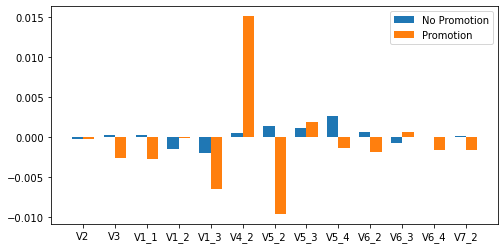

In [22]:
print(lrm_0.coef_)
print(lrm_1.coef_)
fig, ax = plt.subplots()
labels = x_0.columns
x = np.arange(len(labels))
width = 0.35
ax.bar(x= x - width/2, height=lrm_0.coef_, width=width, label='No Promotion')
ax.bar(x= x + width/2, height=lrm_1.coef_, width=width, label='Promotion')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.set_size_inches((8, 4))
plt.show()

Now we have something to work with. Assuming V4_2 is a good sign and V5_2 is a bad one, what kind of results are we looking at?

In [23]:
truly_naive_0 = no_promotion[(no_promotion['V4'] == 2) & (no_promotion['V5'] != 2)]
truly_naive_1 = promotion[(promotion['V4'] == 2) & (promotion['V5'] != 2)]
print(my_nir(truly_naive_0['purchase'], truly_naive_1['purchase']))

752.1247499137635


In [24]:
cost = 0.15
print(truly_naive_1.shape)
truly_naive_1.shape[0] * cost

(14511, 10)


2176.65

In [25]:
print(inc_resp_rate(truly_naive_0['purchase'], truly_naive_1['purchase']))

(0.02018313520717913, 5.049452558369499e-39)


Note: This is a substantial improvement, and we hit a positive level! Since this is very inexact, we're pretty interested in outlay. We spent \\$2176, we reached out to almost 15000 people and we made \\$750, or about 5 cents per person reached. More generally, if this sample is representative, we can target about a third of the customer base with this promotion and make roughly 30% profits. That's good enough to have this as a tentative base model, and since there won't be any hyperparameter tuning we can just run it on the test set to see how it generalizes.

## Model 1

Send the promotion to all customers with V4 == 2 and V5 != 2.

In [26]:
naive_tester = pd.concat([X_testl, y_testl], axis=1)
truly_naive_test_exp = naive_tester[(naive_tester['Promotion'] == 'Yes') & (naive_tester['V4'] == 2) & (naive_tester['V5'] != 2)]
truly_naive_test_cont = naive_tester[(naive_tester['Promotion'] == 'No') & (naive_tester['V4'] == 2) & (naive_tester['V5'] != 2)]

cost = 0.15

nir_model1 = my_nir(truly_naive_test_cont['purchase'], truly_naive_test_exp['purchase'])
irr_model1 = inc_resp_rate(truly_naive_test_cont['purchase'], truly_naive_test_exp['purchase'])
cost_model1 = truly_naive_test_exp.shape[0] * cost

print("Net incremental revenue:", nir_model1)
print("Incremental response rate:", irr_model1)
print("Cost of promotion:", cost_model1)
print("Percent profit: {:.3}%".format(nir_model1 * 100. / cost_model1))

Net incremental revenue: 134.49044321329643
Incremental response rate: (0.01862215036933198, 8.026165577571097e-10)
Cost of promotion: 556.9499999999999
Percent profit: 24.1%


Some reduction on the test set, but still a believable and significant improvement. We'd like our final model to do better than this, since there ought to be more information somewhere in the other features. However, we can go right ahead and build model 2 to start.

## Model 2

Include anyone whose prediction from the linear regression model trained on promotion data is 0.015 greater than their prediction from the model trained on the no promotion data.

Now, this can cause more or less trouble depending on how you think of it. The choice of threshold interprets the prediction of the linear regression as a probability. This, at least at a surface level, works because minimizing mean squared error leads to a predictor of the mean, and the mean of categorical data encoded as 0s and 1s is the fraction of 1s. Of course, there's nothing preventing linear regression from predicting a negative value or a value above 1, which are not valid percentages. Here, we're not necessarily that worried about it. We're primarily interested in the incremental response rate, which can be between -1 and 1. As will become apparently later, this value never goes past a few percentage points in absolute value. Within this small range, it's not immediately apparent how each of the features should be modeled, but a linear dependence is a reasonable guess. We can compare this to the results we get from logistic regression, and also try including it as a feature engineering step in more complex models.

In [27]:
model_2_bools = x_1.apply(lambda row: (lrm_1.predict(row.values.reshape(1, -1)) - lrm_0.predict(row.values.reshape(1, -1)))[0], axis=1).apply(lambda x: x > 0.015)
model_2 = promotion[model_2_bools.to_numpy()]
model_2_ref_bools = x_0.apply(lambda row: (lrm_1.predict(row.values.reshape(1, -1)) - lrm_0.predict(row.values.reshape(1, -1)))[0], axis=1).apply(lambda x: x > 0.015)
model_2_ref = no_promotion[model_2_ref_bools.to_numpy()]

In [29]:
cost = 0.15

nir_model2 = my_nir(model_2_ref['purchase'], model_2['purchase'])
irr_model2 = inc_resp_rate(model_2_ref['purchase'], model_2['purchase'])
cost_model2 = model_2.shape[0] * cost

print("Net incremental revenue:", nir_model2)
print("Incremental response rate:", irr_model2)
print("Cost of promotion:", cost_model2)
print("Percent profit: {:.3}%".format(nir_model2 * 100. / cost_model2))

Net incremental revenue: 883.1957333448845
Incremental response rate: (0.022695353605862896, 1.1303618076524886e-37)
Cost of promotion: 1721.55
Percent profit: 51.3%


Before we actually build a pipeline and do some cross validation, I'd like to get a better look at how things shake out. Specifically, we can make a sort of QQ plot (we verified that the marginal distribution of any two variables was the same for control and experimental groups, but now we can compare the distribution of our prediction metric) as well as looking at how different cutoff values affect the net incremental revenue.

In [30]:
promotion.loc[:, 'lin_reg_diff'] = x_1.apply(lambda row: (lrm_1.predict(row.values.reshape(1, -1)) - lrm_0.predict(row.values.reshape(1, -1)))[0], axis=1)

C:\Users\charl\.virtualenvs\starbucks-9JmFD08z\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\charl\.virtualenvs\starbucks-9JmFD08z\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [31]:
no_promotion.loc[:, 'lin_reg_diff'] = x_0.apply(lambda row: (lrm_1.predict(row.values.reshape(1, -1)) - lrm_0.predict(row.values.reshape(1, -1)))[0], axis=1)

C:\Users\charl\.virtualenvs\starbucks-9JmFD08z\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\charl\.virtualenvs\starbucks-9JmFD08z\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [32]:
sorted_vals = promotion[['purchase', 'lin_reg_diff']].sort_values(by='lin_reg_diff')
sorted_controls = no_promotion[['purchase', 'lin_reg_diff']].sort_values(by='lin_reg_diff')

x_0s = sorted_controls['lin_reg_diff'].to_numpy()
y_0s = sorted_controls['purchase'].to_numpy()
x_1s = sorted_vals['lin_reg_diff'].to_numpy()
y_1s = sorted_vals['purchase'].to_numpy()

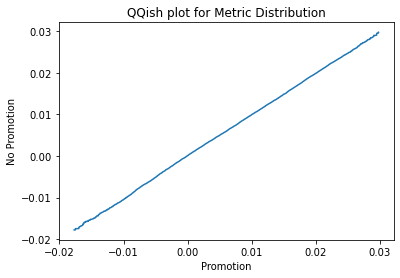

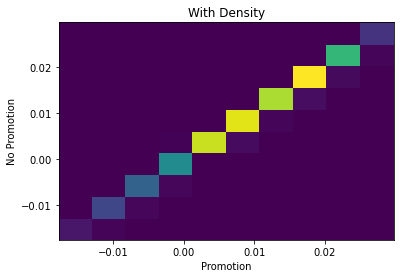

In [37]:
plt.plot(x_0s, sorted(np.random.choice(x_1s, x_0s.size)))
plt.ylabel("No Promotion")
plt.xlabel("Promotion")
plt.title("QQish plot for Metric Distribution")
plt.show()
plt.hist2d(x_0s, sorted(np.random.choice(x_1s, x_0s.size)))
plt.ylabel("No Promotion")
plt.xlabel("Promotion")
plt.title("With Density")
plt.show()

At this point I think we're justified in building two models and comparing them: specifically, I'm going to use the same cutoff value in both groups to get a sense of the incremental response rate for that subset.

In [43]:
def visually_evaluate(rec_control, purch_control, rec_promote, purch_promote):
    data_nir = np.zeros(rec_promote.size)
    data_irr = np.zeros(rec_promote.size)
    control_idx = 0
    for i in range(rec_promote.size):
        while control_idx < rec_control.size - 1 and rec_control[control_idx] < rec_promote[i]:
            control_idx += 1
        data_irr[i], _ = inc_resp_rate(purch_control[control_idx:], purch_promote[i:])
        data_nir[i] = my_nir(purch_control[control_idx:], purch_promote[i:])
    plt.plot(np.linspace(0., 1., num=data_nir.size), data_nir)
    plt.xlabel("Fraction Excluded")
    plt.ylabel("Net Incremental Revenue")
    plt.title("Net Incremental Revenue vs Group Size")
    plt.show()
    plt.plot(rec_promote, data_nir)
    plt.xlabel("Metric Cutoff Value")
    plt.ylabel("Net Incremental Revenue")
    plt.title("Net Incremental Revenue vs Cutoff")
    plt.show()

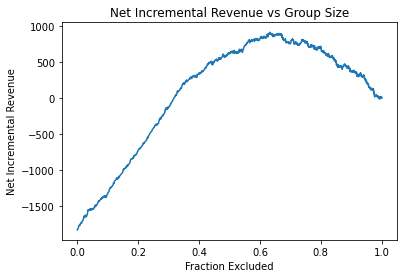

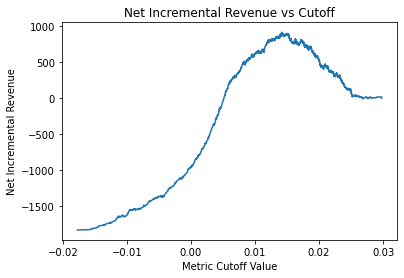

In [44]:
visually_evaluate(x_0s, y_0s, x_1s, y_1s)

So this last graph is the strongest argument in favor of using the metric. It's visually pretty clear that 0.015, which represents the incremental response rate at which the expected value of sending a promotion to a customer is 0, also represents the maximum net incremental revenue. This metric is some sort of estimator for the incremental response rate (from which we can derive the net incremental revenue. Of course, that doesn't mean it's a great estimator.

Just as a quick reference before moving onto pipelines, let's check out logistic regression. Logistic regression will also minimize a loss function and estimate the probability of class membership (in this case the percent chance of purchase). However, it assumes the features have a different relationship with the variable of interest.

## Model 3

See model 2, but use predict_proba on logistic_regresion

In [45]:
x_0 = no_promote_reg.drop(["ID", "Promotion"], axis=1)
x_1 = promote_reg.drop(["ID", "Promotion"], axis=1)
y_0 = y_trainl_np
y_1 = y_trainl_p
rrm_0 = LogisticRegression(class_weight='balanced')
rrm_1 = LogisticRegression(class_weight='balanced')
rrm_0.fit(x_0, y_0)
rrm_1.fit(x_1, y_1)
print(rrm_0.score(x_0, y_0))
print(rrm_1.score(x_1, y_1))
print(rrm_0.score(x_1, y_1))
print(rrm_1.score(x_0, y_0))

0.5254629629629629
0.5664141935103593
0.5310777754855442
0.5532704178537512


[-0.02330527  0.02807007  0.00366832 -0.23924393 -0.32085227  0.10380801
  0.19990195  0.15623134  0.37065543  0.10550886 -0.10123548  0.0098495
  0.01294525]
[-1.86793073e-04 -1.73547077e-01 -1.46816633e-01 -2.15226573e-02
 -4.60412075e-01  1.14272117e+00 -6.35538303e-01  9.36979723e-02
 -1.02380841e-02 -1.10450068e-01  5.67234156e-02 -5.37524670e-02
 -1.29896717e-01]


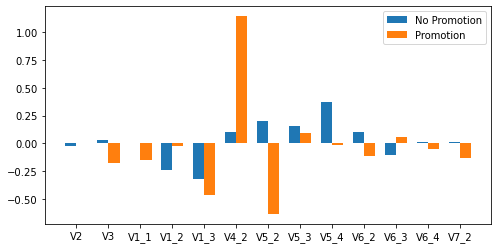

In [47]:
print(rrm_0.coef_[0])
print(rrm_1.coef_[0])
fig, ax = plt.subplots()
labels = x_0.columns
x = np.arange(len(labels))
width = 0.35
ax.bar(x= x - width/2, height=rrm_0.coef_[0], width=width, label='No Promotion')
ax.bar(x= x + width/2, height=rrm_1.coef_[0], width=width, label='Promotion')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.set_size_inches((8, 4))
plt.show()

In [54]:
model_3_bools = x_1.apply(lambda row: (rrm_1.predict_proba(row.values.reshape(1, -1))[:, 1] - rrm_0.predict_proba(row.values.reshape(1, -1))[:, 1])[0], axis=1).apply(lambda x: x > 0.015)
model_3 = promotion[model_3_bools.to_numpy()]
model_3_bools_ref = x_0.apply(lambda row: (rrm_1.predict_proba(row.values.reshape(1, -1))[:, 1] - rrm_0.predict_proba(row.values.reshape(1, -1))[:, 1])[0], axis=1).apply(lambda x: x > 0.015)
model_3_ref = no_promotion[model_3_bools_ref.to_numpy()]

In [55]:
cost = 0.15

nir_model3 = my_nir(model_3_ref['purchase'], model_3['purchase'])
irr_model3 = inc_resp_rate(model_3_ref['purchase'], model_3['purchase'])
cost_model3 = model_3.shape[0] * cost

print("Net incremental revenue:", nir_model2)
print("Incremental response rate:", irr_model2)
print("Cost of promotion:", cost_model2)
print("Percent profit: {:.3}%".format(nir_model2 * 100. / cost_model2))

Net incremental revenue: 883.1957333448845
Incremental response rate: (0.022695353605862896, 1.1303618076524886e-37)
Cost of promotion: 1721.55
Percent profit: 51.3%


In [ ]:

cost = 0.15

print(model_3.head())

print(model_3['purchase'].sum() / model_3.shape[0])
print(no_promotion['purchase'].sum() / no_promotion.shape[0])

print(my_nir(no_promotion['purchase'], model_3['purchase']))
print(inc_resp_rate(no_promotion['purchase'], model_3['purchase']))
print(model_3.shape)
print(model_3.shape[0] * cost)

In [56]:
promotion.loc[:, 'log_reg_diff'] = x_1.apply(lambda row: (rrm_1.predict_proba(row.values.reshape(1, -1)) - rrm_0.predict_proba(row.values.reshape(1, -1)))[0][1], axis=1)

C:\Users\charl\.virtualenvs\starbucks-9JmFD08z\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\charl\.virtualenvs\starbucks-9JmFD08z\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [57]:
no_promotion.loc[:, 'log_reg_diff'] = x_0.apply(lambda row: (rrm_1.predict_proba(row.values.reshape(1, -1)) - rrm_0.predict_proba(row.values.reshape(1, -1)))[0][1], axis=1)

C:\Users\charl\.virtualenvs\starbucks-9JmFD08z\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\charl\.virtualenvs\starbucks-9JmFD08z\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [58]:
sorted_vals = promotion[['purchase', 'log_reg_diff']].sort_values(by='log_reg_diff')
sorted_controls = no_promotion[['purchase', 'log_reg_diff']].sort_values(by='log_reg_diff')

x3_0s = sorted_controls['log_reg_diff'].values
y3_0s = sorted_controls['purchase'].values
x3_1s = sorted_vals['log_reg_diff'].values
y3_1s = sorted_vals['purchase'].values

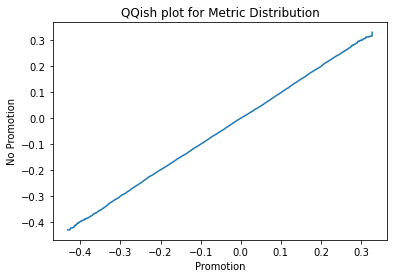

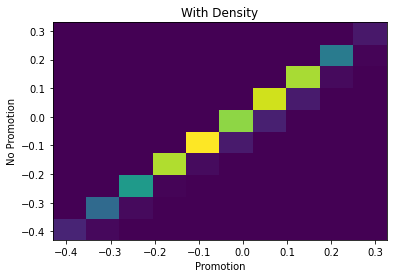

In [59]:
plt.plot(x3_0s, sorted(np.random.choice(x3_1s, x3_0s.size)))
plt.ylabel("No Promotion")
plt.xlabel("Promotion")
plt.title("QQish plot for Metric Distribution")
plt.show()
plt.hist2d(x3_0s, sorted(np.random.choice(x3_1s, x3_0s.size)))
plt.ylabel("No Promotion")
plt.xlabel("Promotion")
plt.title("With Density")
plt.show()

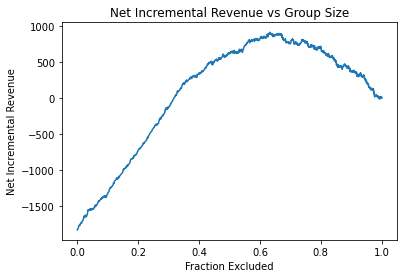

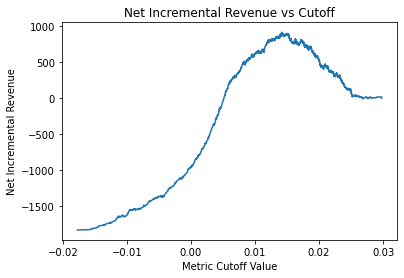

In [60]:
visually_evaluate(x_0s, y_0s, x_1s, y_1s)

In [64]:
promotion.loc[:, ['lin_reg_diff', 'log_reg_diff']].corr()

,lin_reg_diff,log_reg_diff
lin_reg_diff,1.000000,0.987295
log_reg_diff,0.987295,1.000000


In [68]:
no_promotion.loc[:, ['lin_reg_diff', 'log_reg_diff']].corr()

,lin_reg_diff,log_reg_diff
lin_reg_diff,1.000000,0.987578
log_reg_diff,0.987578,1.000000


So as you can see, we're pretty insensitive to model choice here. This leaves the choice to me, and I'm comfortable going with linear regression. Here's why.

In this scenario, the intervention has an impact on a single binary decision. However, the more general form of this might just involve a change in the amount someone spends over a period of time. Modeling this problem as net change in customer spending makes it well suited for a regression problem, where we could easily transform the units into the currency and set the threshold at the exact cost of intervention. Classification won't extend as nicely. Now as far as further modeling goes, I did experiment with that. Grid search over XGBoost parameters didn't lead to anything better than ordinary least squares, and using regression output as a feature didn't provide significant gains. In the end, I favored simplicity, quick training times, and explainability over further potential gains, and I suspected overfitting might be a problem. Of course, since this is an artificial data set, I was curious about how much money I left on the table with this, but we'll have to wait until we set everything up formally for that.

In [69]:
class RegressionTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, cat_cols=['V1', 'V4', 'V5', 'V6', 'V7']):
        self.cat_cols = cat_cols

    def fit(self, X, y=None):
        self.scaler = StandardScaler()
        self.scaler.fit(X['V2'].to_numpy().reshape(-1, 1))
        return self

    def transform(self, X):
        cats = pd.get_dummies(X.loc[:, self.cat_cols], drop_first=True, columns=self.cat_cols)
        X = X.drop(self.cat_cols, axis=1)
        X = X.drop('ID', axis=1)
        X['V2'] = self.scaler.transform(X['V2'].to_numpy().reshape(-1, 1))[:, 0]
        X = pd.concat([X, cats], axis=1)
        return X


Here is where we're able to parameterize various feature engineering steps. I felt good about normalizing `V2` and not `V3`, but I had no real confidence that `V1` was categorical.

In [70]:
class ProbabilityViaMean(BaseEstimator):
    
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept

    def fit(self, X, y):
        X0 = X[X['Promotion'] == 'No'].drop('Promotion', axis=1)
        X1 = X[X['Promotion'] == 'Yes'].drop('Promotion', axis=1)
        y0 = y[y['Promotion'] == 'No']['purchase']
        y1 = y[y['Promotion'] == 'Yes']['purchase']
        self.lrm0 = LinearRegression(fit_intercept=self.fit_intercept)
        self.lrm1 = LinearRegression(fit_intercept=self.fit_intercept)
        self.lrm0.fit(X0, y0)
        self.lrm1.fit(X1, y1)
        
    def predict(self, X):
        y = self.lrm1.predict(X.drop('Promotion', axis=1)) - self.lrm0.predict(X.drop('Promotion', axis=1))
        y_out = X.loc[:, ['Promotion']].copy()
        y_out['Recommended'] = y
        return y_out
        
    

In [73]:
def nir_score(y_true, y_pred):
    base_case = y_true[(y_true['Promotion'] == 'No') & (y_pred['Recommended'] > 0.015)]['purchase']
    promote_case = y_true[(y_true['Promotion'] == 'Yes') & (y_pred['Recommended'] > 0.015)]['purchase']
    nir = my_nir(base_case, promote_case)
    return nir

nir_scorer = make_scorer(nir_score)

In [74]:
pipeline = Pipeline([
    ('featurizer', RegressionTransformer()),
    ('reg', ProbabilityViaMean())
])

In [75]:
y = pd.concat([X_trainl['Promotion'], y_trainl], axis=1)

In [156]:
clf = GridSearchCV(pipeline2, param_grid=parameters2, scoring=nir_scorer2, return_train_score=True, cv=5)
clf.fit(X_trainl, y)
clf.cv_results_

{'mean_fit_time': array([0.07592459, 0.07523866]),
 'std_fit_time': array([0.00139567, 0.00104065]),
 'mean_score_time': array([0.02564368, 0.02533703]),
 'std_score_time': array([0.0009062 , 0.00025575]),
 'param_clf__fit_intercept': masked_array(data=[True, False],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'clf__fit_intercept': True}, {'clf__fit_intercept': False}],
 'split0_test_score': array([129.17706093, 114.44084998]),
 'split1_test_score': array([203.82683616, 190.01728634]),
 'split2_test_score': array([98.19643423, 86.18842021]),
 'split3_test_score': array([ 29.80669371, -15.17678498]),
 'split4_test_score': array([227.2063685 , 213.22288557]),
 'mean_test_score': array([137.64353219, 117.73955145]),
 'std_test_score': array([71.63496369, 81.25719235]),
 'rank_test_score': array([1, 2], dtype=int32),
 'split0_train_score': array([697.87598253, 623.51996419]),
 'split1_train_score': array([594.57180205, 604.41776662]),

In [48]:
y_for_analysis = y.copy()
y_for_analysis['Recommended'] = y_pred_2['Recommended']
y_for_promotion = y_for_analysis[y_for_analysis['Promotion'] == 'Yes'].sort_values(by='Recommended')
y_for_control = y_for_analysis[y_for_analysis['Promotion'] == 'No'].sort_values(by='Recommended')
rec_y_promote = y_for_promotion['Recommended'].to_numpy()
purch_y_promote = y_for_promotion['purchase'].to_numpy()
rec_y_control = y_for_control['Recommended'].to_numpy()
purch_y_control = y_for_control['purchase'].to_numpy()

In [54]:
data_nir = np.zeros(rec_y_promote.size)
data_irr = np.zeros(rec_y_promote.size)
control_idx = 0
for i in range(rec_y_promote.size):
    while control_idx < rec_y_control.size - 1 and rec_y_control[control_idx] < rec_y_promote[i]:
        control_idx += 1
    data_irr[i], _ = inc_resp_rate(purch_y_control[control_idx:], purch_y_promote[i:])
    data_nir[i] = my_nir(purch_y_control[control_idx:], purch_y_promote[i:])

In [158]:
y_test = pd.concat([X_testl['Promotion'], y_testl], axis=1)

In [107]:
y_for_analysis = y_test.copy()
y_for_analysis['Recommended'] = y_test_pred['Recommended']
y_for_promotion = y_for_analysis[y_for_analysis['Promotion'] == 'Yes'].sort_values(by='Recommended')
y_for_control = y_for_analysis[y_for_analysis['Promotion'] == 'No'].sort_values(by='Recommended')
rec_y_promote = y_for_promotion['Recommended'].to_numpy()
purch_y_promote = y_for_promotion['purchase'].to_numpy()
rec_y_control = y_for_control['Recommended'].to_numpy()
purch_y_control = y_for_control['purchase'].to_numpy()

In [108]:
data_nir = np.zeros(rec_y_promote.size)
data_irr = np.zeros(rec_y_promote.size)
control_idx = 0
for i in range(rec_y_promote.size):
    while control_idx < rec_y_control.size - 1 and rec_y_control[control_idx] < rec_y_promote[i]:
        control_idx += 1
    data_irr[i], _ = inc_resp_rate(purch_y_control[control_idx:], purch_y_promote[i:])
    data_nir[i] = my_nir(purch_y_control[control_idx:], purch_y_promote[i:])

In [155]:
with_v1 = ['V1', 'V4', 'V5', 'V6', 'V7']
without_v1 = ['V4', 'V5', 'V6', 'V7']

parameters2 = {
    'featurizer__cat_cols': [with_v1, without_v1],
    'reg__fit_intercept': [True, False],
}

In [87]:
def clf_nir_score(y_true, y_pred):
    base_case = y_true[(y_true['Promotion'] == 'No') & (y_pred['do_promote'] == 1)]['purchase']
    promote_case = y_true[(y_true['Promotion'] == 'Yes') & (y_pred['do_promote'] == 1)]['purchase']
    nir = my_nir(base_case, promote_case)
    return nir

reg_scorer = make_scorer(nir_score)

In [152]:
with_v1 = ['V1', 'V4', 'V5', 'V6', 'V7']
without_v1 = ['V4', 'V5', 'V6', 'V7']

parameters3 = {
#     'featurizer__cat_cols': [with_v1, without_v1],
#     'clf__dual': [False, True],
#     'clf__penalty': ['l1', 'l2'],
#     'clf__loss': ['hinge', 'squared_hinge'],
    'clf__cutoff': [-1., 0., 0.005, 0.01, 0.015, 0.02]
}

In [92]:
y = pd.concat([X_trainl['Promotion'], y_trainl], axis=1)

In [154]:
clf3 = GridSearchCV(pipeline3, param_grid=parameters3, scoring=nir_scorer, return_train_score=True, cv=5)
clf3.fit(X_trainl, y)
clf3.cv_results_

{'mean_fit_time': array([3.78591833, 2.88922901, 2.1885704 , 1.67287235, 1.06889801,
        0.53170056]),
 'std_fit_time': array([0.08963477, 0.03397091, 0.03894944, 0.05831176, 0.0823119 ,
        0.08094891]),
 'mean_score_time': array([0.0287282 , 0.02844443, 0.02884345, 0.02911172, 0.03635688,
        0.02932134]),
 'std_score_time': array([0.00082049, 0.00095297, 0.00073539, 0.00075715, 0.01346476,
        0.0005563 ]),
 'param_clf__cutoff': masked_array(data=[-1.0, 0.0, 0.005, 0.01, 0.015, 0.02],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'clf__cutoff': -1.0},
  {'clf__cutoff': 0.0},
  {'clf__cutoff': 0.005},
  {'clf__cutoff': 0.01},
  {'clf__cutoff': 0.015},
  {'clf__cutoff': 0.02}],
 'split0_test_score': array([ 141.47647059,  141.47647059,  141.47647059,  133.84615385,
          72.631961  , -222.90553561]),
 'split1_test_score': array([ 240.16391437,  240.16391437,  240.16391437,  188.354450

In [110]:
y_pred_ols = clf2.predict(X_trainl)
y_pred_test_ols = clf2.predict(X_testl)

In [111]:
y_for_analysis = y.copy()
y_for_analysis['Recommended'] = y_pred_ols['Recommended']
y_for_promotion = y_for_analysis[y_for_analysis['Promotion'] == 'Yes'].sort_values(by='Recommended')
y_for_control = y_for_analysis[y_for_analysis['Promotion'] == 'No'].sort_values(by='Recommended')
rec_y_promote = y_for_promotion['Recommended'].to_numpy()
purch_y_promote = y_for_promotion['purchase'].to_numpy()
rec_y_control = y_for_control['Recommended'].to_numpy()
purch_y_control = y_for_control['purchase'].to_numpy()

In [112]:
data_nir = np.zeros(rec_y_promote.size)
data_irr = np.zeros(rec_y_promote.size)
control_idx = 0
for i in range(rec_y_promote.size):
    while control_idx < rec_y_control.size - 1 and rec_y_control[control_idx] < rec_y_promote[i]:
        control_idx += 1
    data_irr[i], _ = inc_resp_rate(purch_y_control[control_idx:], purch_y_promote[i:])
    data_nir[i] = my_nir(purch_y_control[control_idx:], purch_y_promote[i:])

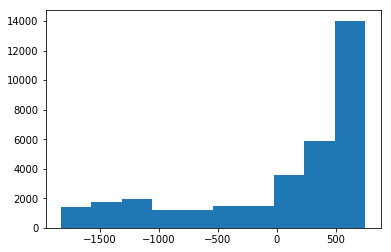

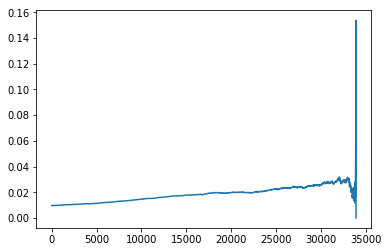

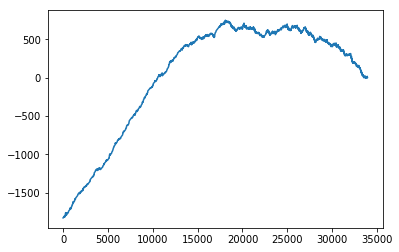

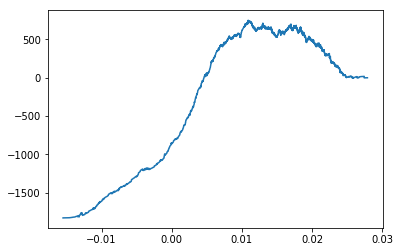

In [113]:
plt.hist(data_nir)
plt.show()
plt.plot(data_irr)
plt.show()
plt.plot(data_nir)
plt.show()
plt.plot(rec_y_promote, data_nir)
plt.show()

In [114]:
y_for_analysis = y_test.copy()
y_for_analysis['Recommended'] = y_pred_test_ols['Recommended']
y_for_promotion = y_for_analysis[y_for_analysis['Promotion'] == 'Yes'].sort_values(by='Recommended')
y_for_control = y_for_analysis[y_for_analysis['Promotion'] == 'No'].sort_values(by='Recommended')
rec_y_promote = y_for_promotion['Recommended'].to_numpy()
purch_y_promote = y_for_promotion['purchase'].to_numpy()
rec_y_control = y_for_control['Recommended'].to_numpy()
purch_y_control = y_for_control['purchase'].to_numpy()

In [115]:
data_nir = np.zeros(rec_y_promote.size)
data_irr = np.zeros(rec_y_promote.size)
control_idx = 0
for i in range(rec_y_promote.size):
    while control_idx < rec_y_control.size - 1 and rec_y_control[control_idx] < rec_y_promote[i]:
        control_idx += 1
    data_irr[i], _ = inc_resp_rate(purch_y_control[control_idx:], purch_y_promote[i:])
    data_nir[i] = my_nir(purch_y_control[control_idx:], purch_y_promote[i:])

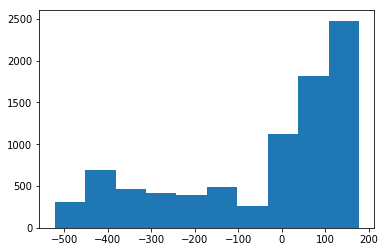

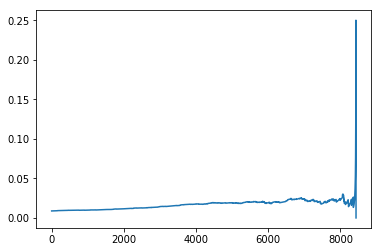

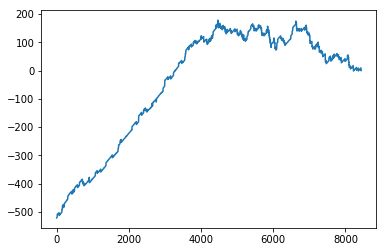

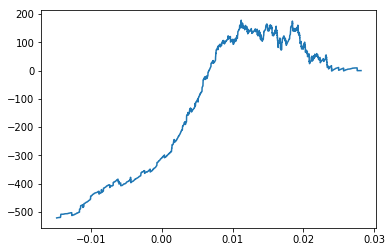

In [116]:
plt.hist(data_nir)
plt.show()
plt.plot(data_irr)
plt.show()
plt.plot(data_nir)
plt.show()
plt.plot(rec_y_promote, data_nir)
plt.show()

We need some inputs. This is a great prefiltering stage, even in test. What's more, it's quick and there's not that much tuning to be done. However, what can we do with this filtered data? At that point, maybe it's worth trying to tune a classifier with balanced weights. Or rather, why not just make this a feature engineering step?

In [21]:
class RegressionTransformer2(BaseEstimator, TransformerMixin):

    def __init__(self, cat_cols=['V1', 'V4', 'V5', 'V6', 'V7']):
        self.cat_cols = cat_cols

    def fit(self, X, y=None):
        self.scaler = StandardScaler()
        self.scaler.fit(X['V2'].to_numpy().reshape(-1, 1))
        return self

    def transform(self, X):
        cats = pd.get_dummies(X.loc[:, self.cat_cols], drop_first=True, columns=self.cat_cols)
        X = X.drop(self.cat_cols, axis=1)
        X = X.drop('ID', axis=1)
        X['V2'] = self.scaler.transform(X['V2'].to_numpy().reshape(-1, 1))[:, 0]
        X['purchase'] = X.apply(lambda row: row['purchase'] if row['Promotion'] == 'Yes' else row['purchase'] * -1.03, axis=1)
        X = pd.concat([X, cats], axis=1)
        return X


In [22]:
def jr_score(y_true, y_pred):
    base_rate = y_true[(y_true['Promotion'] == 'No') & (y_pred['Recommended'] > 0.)]['purchase'].sum() / y_true[y_true['Promotion'] == 'No'].shape[0]
    promote_rate = y_true[(y_true['Promotion'] == 'Yes') & (y_pred['Recommended'] > 0.)]['purchase'].sum() / y_true[y_true['Promotion'] == 'Yes'].shape[0]
    inc_rate = promote_rate - base_rate
    return inc_rate

jr_scorer = make_scorer(jr_score)

In [77]:
def transform_for_regression2(data, cat_cols=['V1', 'V4', 'V5', 'V6', 'V7']):
    data = data.copy()
    cats = pd.get_dummies(data.loc[:, cat_cols], drop_first=True, columns=cat_cols)
    data = data.drop(cat_cols, axis=1)
    data['V2'] = (data['V2'] - data['V2'].mean()) / data['V2'].std()
    data = pd.concat([data, cats], axis=1)
    data['purchase'] = data.apply(lambda row: row['purchase'] if row['Promotion'] == 'Yes' else row['purchase'] * -1, axis=1)
    return data

In [25]:
local_train_data.head()

,ID,Promotion,V1,V2,V3,V4,V5,V6,V7,purchase
66588,99250,Yes,3,34.470493,-1.078506,1,1,1,2,0
62125,92564,No,1,28.065819,-1.165083,1,1,3,1,0
27827,41307,Yes,1,27.142590,-1.511395,1,3,3,2,0
66648,99341,Yes,3,28.782344,-1.078506,1,1,1,2,0
47392,70517,No,2,39.605508,-0.645617,2,3,1,2,0


In [78]:
new_exp = transform_for_regression2(local_train_data)

In [29]:
new_exp.head(400).drop_duplicates(subset='purchase')

,ID,Promotion,V2,V3,purchase,V1_1,V1_2,V1_3,V4_2,V5_2,V5_3,V5_4,V6_2,V6_3,V6_4,V7_2
66588,99250,Yes,0.896915,-1.078506,0.00,0,0,1,0,0,0,0,0,0,0,1
33394,49666,Yes,0.248060,-0.645617,1.00,1,0,0,1,0,0,0,0,0,1,1
31595,46929,No,-0.094882,1.345672,-1.03,0,1,0,1,1,0,0,0,0,1,1


In [79]:
new_exp_X = new_exp.drop(['ID', 'Promotion'], axis=1)
new_exp_y = new_exp['purchase']

In [80]:
new_exp_lrm = LinearRegression()
new_exp_lrm.fit(new_exp_X, new_exp_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [81]:
new_exp_y_pred = new_exp_lrm.predict(new_exp_X)

In [82]:
(new_exp_y_pred > 0.).sum()

31445

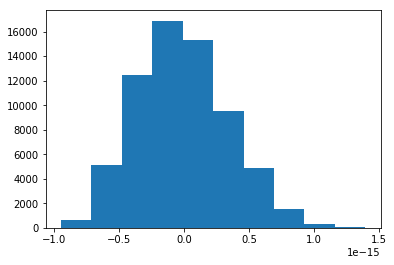

In [83]:
plt.hist(new_exp_y_pred[(new_exp_y_pred > -0.75) & (new_exp_y_pred < 0.75)])
plt.show()

In [84]:
def evaluate(y_true, rec_vals, y_promotions):
    y_for_analysis = pd.DataFrame(data={
        'purchase': y_true,
        'Recommended': rec_vals,
        'Promotion': y_promotions,
    })
    y_for_promotion = y_for_analysis[y_for_analysis['Promotion'] == 'Yes'].sort_values(by='Recommended')
    print(y_for_promotion.shape)
    print(y_for_promotion['purchase'].sum())
    y_for_control = y_for_analysis[y_for_analysis['Promotion'] == 'No'].sort_values(by='Recommended')
    print(y_for_control.shape)
    print(y_for_control['purchase'].sum())
    rec_y_promote = y_for_promotion['Recommended'].to_numpy()
    purch_y_promote = y_for_promotion['purchase'].to_numpy()
    rec_y_control = y_for_control['Recommended'].to_numpy()
    purch_y_control = y_for_control['purchase'].to_numpy()
    data_nir = np.zeros(rec_y_promote.size)
    data_irr = np.zeros(rec_y_promote.size)
    control_idx = 0
    for i in range(rec_y_promote.size):
        while control_idx < rec_y_control.size - 1 and rec_y_control[control_idx] < rec_y_promote[i]:
            control_idx += 1
        print(control_idx, ':', purch_y_control[control_idx:].sum(), "vs", purch_y_promote[i:].sum())
        data_irr[i], _ = inc_resp_rate(purch_y_control[control_idx:], purch_y_promote[i:])
        data_nir[i] = my_nir(purch_y_control[control_idx:], purch_y_promote[i:])
    plt.hist(data_nir)
    plt.show()
    plt.plot(data_irr)
    plt.show()
    plt.plot(data_nir)
    plt.show()
    plt.plot(rec_y_promote, data_nir)
    plt.show()

(33931, 3)
580
(33696, 3)
252
252 : 0 vs 580
252 : 0 vs 580
255 : 0 vs 580
255 : 0 vs 580
256 : 0 vs 580
256 : 0 vs 580
256 : 0 vs 580
256 : 0 vs 580
256 : 0 vs 580
257 : 0 vs 580
258 : 0 vs 580
258 : 0 vs 580
259 : 0 vs 580
259 : 0 vs 580
259 : 0 vs 580
260 : 0 vs 580
262 : 0 vs 580
263 : 0 vs 580
264 : 0 vs 580
264 : 0 vs 580
266 : 0 vs 580
268 : 0 vs 580
268 : 0 vs 580
268 : 0 vs 580
268 : 0 vs 580
268 : 0 vs 580
268 : 0 vs 580
268 : 0 vs 580
269 : 0 vs 580
271 : 0 vs 580
273 : 0 vs 580
275 : 0 vs 580
275 : 0 vs 580
275 : 0 vs 580
276 : 0 vs 580
276 : 0 vs 580
277 : 0 vs 580
277 : 0 vs 580
277 : 0 vs 580
279 : 0 vs 580
279 : 0 vs 580
279 : 0 vs 580
282 : 0 vs 580
282 : 0 vs 580
282 : 0 vs 580
284 : 0 vs 580
284 : 0 vs 580
285 : 0 vs 580
287 : 0 vs 580
288 : 0 vs 580
288 : 0 vs 580
289 : 0 vs 580
289 : 0 vs 580
290 : 0 vs 580
290 : 0 vs 580
291 : 0 vs 580
294 : 0 vs 580
294 : 0 vs 580
297 : 0 vs 580
297 : 0 vs 580
297 : 0 vs 580
297 : 0 vs 580
298 : 0 vs 580
301 : 0 vs 580
302 : 0 vs

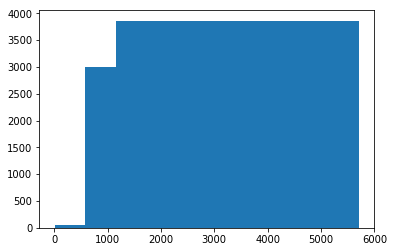

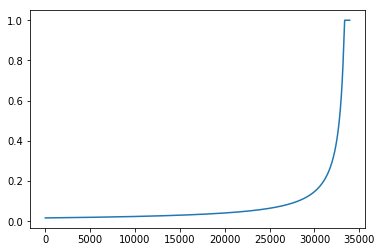

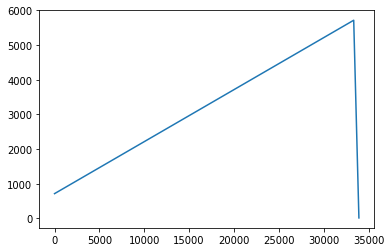

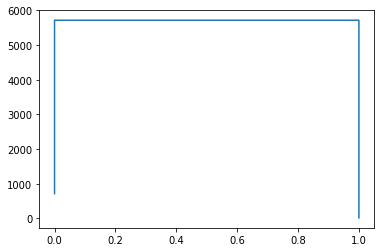

In [85]:
evaluate(local_train_data['purchase'], new_exp_y_pred, local_train_data['Promotion'])

In [48]:
y_for_analysis = y.copy()
y_for_analysis['Recommended'] = y_pred_2['Recommended']
y_for_promotion = y_for_analysis[y_for_analysis['Promotion'] == 'Yes'].sort_values(by='Recommended')
y_for_control = y_for_analysis[y_for_analysis['Promotion'] == 'No'].sort_values(by='Recommended')
rec_y_promote = y_for_promotion['Recommended'].to_numpy()
purch_y_promote = y_for_promotion['purchase'].to_numpy()
rec_y_control = y_for_control['Recommended'].to_numpy()
purch_y_control = y_for_control['purchase'].to_numpy()

In [54]:
data_nir = np.zeros(rec_y_promote.size)
data_irr = np.zeros(rec_y_promote.size)
control_idx = 0
for i in range(rec_y_promote.size):
    while control_idx < rec_y_control.size - 1 and rec_y_control[control_idx] < rec_y_promote[i]:
        control_idx += 1
    data_irr[i], _ = inc_resp_rate(purch_y_control[control_idx:], purch_y_promote[i:])
    data_nir[i] = my_nir(purch_y_control[control_idx:], purch_y_promote[i:])
plt.hist(data_nir)
plt.show()
plt.plot(data_irr)
plt.show()
plt.plot(data_nir)
plt.show()
plt.plot(rec_y_promote, data_nir)
plt.show()

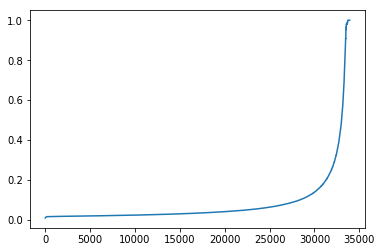

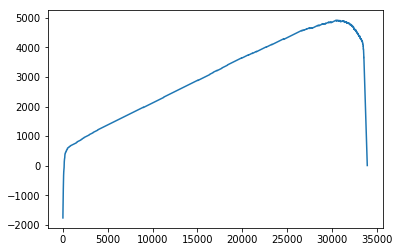

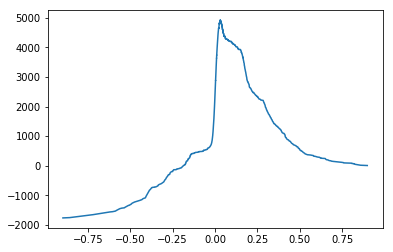

In [159]:
pipeline2.fit(X_trainl, y)
print(nir_score2(y_test, pipeline2.predict(X_testl)))

241.05157452764172


In [166]:
X_train

,ID,Promotion,V1,V2,V3,V4,V5,V6,V7
0,1,No,2,30.443518,-1.165083,1,1,3,2
1,3,No,3,32.159350,-0.645617,2,3,2,2
2,4,No,2,30.431659,0.133583,1,1,4,2
3,5,No,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,3,28.044332,-0.385883,1,1,2,2
...,...,...,...,...,...,...,...,...,...
84529,126180,No,1,30.084876,1.345672,1,1,3,1
84530,126181,Yes,3,33.501485,-0.299306,1,1,4,1
84531,126182,No,1,31.492019,1.085939,2,3,2,2
84532,126183,No,1,37.766106,0.999361,2,2,1,2


In [162]:
final_pipeline = pipeline2
y_final = pd.concat([X_train['Promotion'], y_train], axis=1)
final_pipeline.fit(X_train, y_final)

Pipeline(memory=None,
     steps=[('featurizer', RegressionTransformer(cat_cols=['V1', 'V4', 'V5', 'V6', 'V7'])), ('clf', ProbabilityViaMean2(fit_intercept=True))])

In [163]:
print(nir_score2(y_final, final_pipeline.predict(X_train)))

1076.046527626119


In [71]:
class ProbabilityViaMeanAugment(BaseEstimator, TransformerMixin):
    
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept

    def fit(self, X, y):
        X0 = X[X['Promotion'] == 'No'].drop('Promotion', axis=1)
        X1 = X[X['Promotion'] == 'Yes'].drop('Promotion', axis=1)
        y0 = y[y['Promotion'] == 'No']['purchase']
        y1 = y[y['Promotion'] == 'Yes']['purchase']
        self.lrm0 = LinearRegression(fit_intercept=self.fit_intercept)
        self.lrm1 = LinearRegression(fit_intercept=self.fit_intercept)
        self.lrm0.fit(X0, y0)
        self.lrm1.fit(X1, y1)
        return self
        
    def transform(self, X):
        y = self.lrm1.predict(X.drop('Promotion', axis=1)) - self.lrm0.predict(X.drop('Promotion', axis=1))
        X['Recommended'] = y
        return X

In [173]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    df['Promotion'] = df.apply(lambda row: 'Yes', axis=1)
    df['ID'] = df.apply(lambda row: 1, axis=1)
    y_pred = final_pipeline.predict(df)
    promotion = y_pred['Recommended'].apply(lambda val: 'Yes' if val > 0.015 else 'No')
    
    
    return promotion

In [174]:
predicted = promotion_strategy(train_data.drop('purchase', axis=1))

In [176]:
y_pred_final = train_data.loc[:, ['Promotion']]
y_pred_final['do_promote'] = predicted.apply(lambda val: 1 if val == 'Yes' else 0)
print(nir_score(y_final, y_pred_final))

1076.046527626119


It works! We should be underfitting a bit, but this is what I got

In [ ]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)